# **Analytics SeneCard** - Implementation of Business Questions

---

ISIS-3510 Construcción de Aplicaciones Móviles

Section 2 Team 21

## **Database Connection and Libraries**

The code authenticates a Python app with Firebase using a service account key **(key.json)** and initializes a connection to Firestore. Then, it creates a Firestore client **(db)** to interact with the database for reading and writing data.

In [32]:
# Import necessary libraries to manage the information
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Import library of firebase
import firebase_admin
from firebase_admin import credentials, firestore

if not firebase_admin._apps:
    cred = credentials.Certificate('senecard-aafad-firebase-adminsdk-39ohd-29191d9ca9.json')
    firebase_admin.initialize_app(cred)

db = firestore.client()

# **Business Questions** - Sprint 2

## **Implementation Business Question 1**

*What is the average QR code access time?*

This question is classified as Type 1 because it focuses on summarizing and analyzing existing data to describe a specific metric: the average QR code access time. The significance of this question lies in the fact that if QR code access time is too long, it can frustrate users, resulting in a poor overall experience. In an app where QR codes are integral to functionality, reducing access delays is crucial to maintaining user engagement and satisfaction. A seamless and quick QR scanning process not only improves the app’s usability but also enhances its appeal, directly contributing to the app’s success. This importance is further underscored by the fact that the QR code is essential for the app's core functionality, allowing the businessOwner to access uniandesMember information instantly by scanning the code.

To address this question, we collect data each time a uniandesMember accesses the QR code view. This data includes the date of the QR code access, the access time in milliseconds, and the uniandesMember's ID. This information is then stored in a Firebase collection named "analyticsBusinessQuestion1" for further analysis.

After saving this information, we retrieve it from Firebase and use a pandas DataFrame to manage and process the records.

In [26]:
# Instance of collection analytics business question 1
coleccion_analitics_business_question_1 = db.collection('AnalyticsBusinessQuestions').document('sprint2').collection('businessQuestion1')

# List of documents from the collection
docs = list(coleccion_analitics_business_question_1.stream())

# Transforme from firebase collection to pandas dataframe
data_df_analytics_business_question_1 = []
for doc in docs:
    data_dict_df_analytics_business_question_1 = doc.to_dict()
    data_dict_df_analytics_business_question_1['document_id'] = doc.id
    data_df_analytics_business_question_1.append(data_dict_df_analytics_business_question_1)

df_analytics_business_question_1 = pd.DataFrame(data_df_analytics_business_question_1)
df_analytics_business_question_1.head()

,uniandesMemberId,accessTime,document_id
0,TekL68dg4S5UIGfiZt1K,3000,JWlFhAnmHJ5lJRO7U9PQ
1,TekL68dg4S5UIGfiZt1K,306,P0jBtxTHO1C9fn6rHwgV
2,TekL68dg4S5UIGfiZt1K,4500,QdH7jBxGZWL4QXXSse20
3,TekL68dg4S5UIGfiZt1K,4451,RapXhdPX2lS6x5B8PDmQ
4,TekL68dg4S5UIGfiZt1K,2500,dkrI7MI0YU49yNGC7QyY


Next, we transform the data to calculate the minimum, maximum, and average QR code access times. These statistics, along with the distribution of access times, are then visualized in a plot.

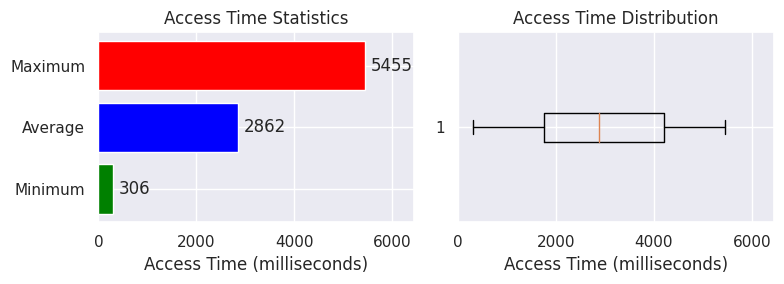

In [27]:
# Calculate statistics
min_time = df_analytics_business_question_1['accessTime'].min()
max_time = df_analytics_business_question_1['accessTime'].max()
mean_time = df_analytics_business_question_1['accessTime'].mean()

# Graph the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Horizontal bar chart (minimum, average, maximum)
bars = axes[0].barh(['Minimum', 'Average', 'Maximum'], [min_time, mean_time, max_time], color=['green', 'blue', 'red'])
for bar in bars:
    axes[0].text(bar.get_width() + 100, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.0f}', va='center')
axes[0].set_xlim(0, max_time + 1000)
axes[0].set_xlabel('Access Time (milliseconds)')
axes[0].set_title('Access Time Statistics')

# Box and whisker plot
axes[1].boxplot(df_analytics_business_question_1['accessTime'], vert=False)
axes[1].set_xlim(0, max_time + 1000)
axes[1].set_xlabel('Access Time (milliseconds)')
axes[1].set_title('Access Time Distribution')

# Show plots
plt.tight_layout()
plt.show()

## **Implementation Business Question 2**

*What are the most and the least consulted stores in the app?*


In [ ]:
import pandas as pd

stores_analytics_ref = db.collection('storesAnalytics')
docs_analytics = stores_analytics_ref.stream()

stores_ref = db.collection('stores')
docs_stores = stores_ref.stream()

store_name_mapping = {}

for doc in docs_stores:
    store_data = doc.to_dict()
    store_name_mapping[doc.id] = store_data.get('name', 'Unknown Store')

store_analytics_data = []
unknown_store_count = 0

for doc in docs_analytics:
    analytics_data = doc.to_dict()
    store_id = analytics_data.get('store_id')
    times_visited = analytics_data.get('timesVisitedLastFiveDays', 0)  # Default to 0 if field is missing

    store_name = store_name_mapping.get(store_id, 'Unknown Store')

    if store_name == 'Unknown Store':
        unknown_store_count += 1
        store_name = f'Unknown Store {unknown_store_count}'

    store_analytics_data.append({
        'store_id': store_id,
        'store_name': store_name,
        'timesVisitedLastFiveDays': times_visited
    })

df_store_analytics = pd.DataFrame(store_analytics_data)
df_store_analytics.head()

,store_id,store_name,timesVisitedLastFiveDays
0,wO7VkiBRzigpY5bvTfzp,Unknown Store 1,18
1,EmjDoJdCztWy8rZaacwZ,Unknown Store 2,13
2,LrupjtaDhefpTlSo28Oq,Hornitos,13
3,JLLPCvGOlzJ7dpr6D4oV,Mac Donalds,20
4,umSX5VklT2fZc1If9euj,Wendy's,6
5,vpMbEwQvJ5SBjnzU1TGf,la comida de alejo,13
6,v7k19yvii87S9c3f2T50,Pizza Hut,13
7,EmjDoJdCztWy8rZaacwZ,Unknown Store 3,21
8,bgsYXfOUTzSgRsYoIXvc,Fast Super Food,14
9,EmjDoJdCztWy8rZaacwZ,Unknown Store 4,6


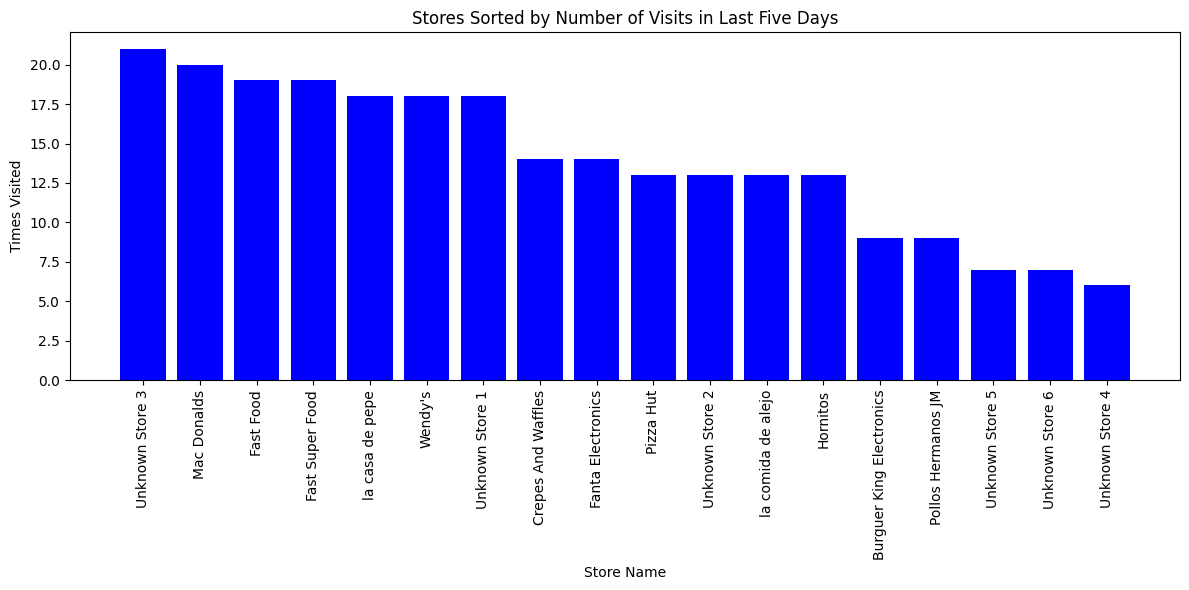

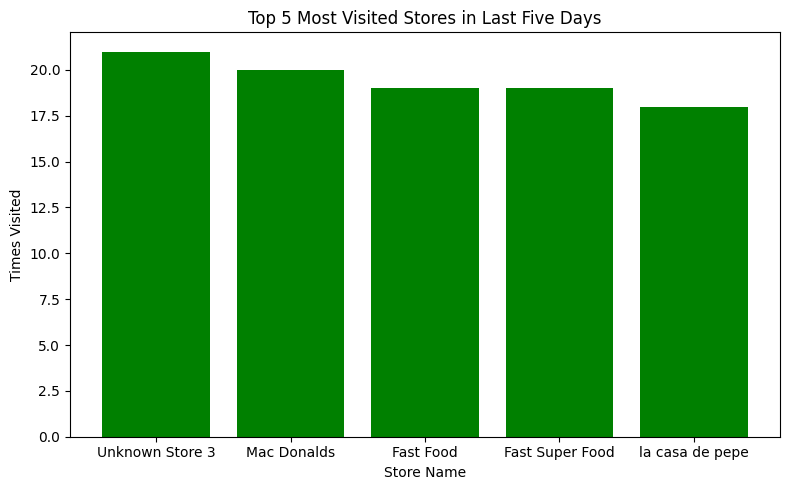

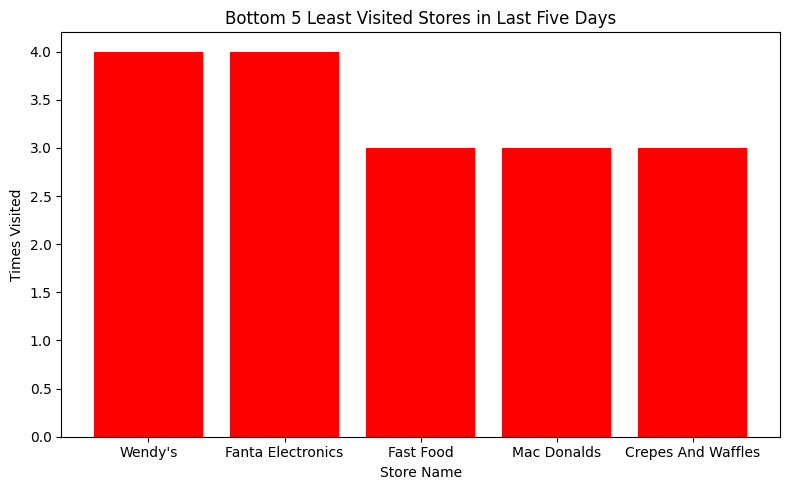

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_stores_sorted = df_store_analytics.sort_values(by='timesVisitedLastFiveDays', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(df_stores_sorted['store_name'], df_stores_sorted['timesVisitedLastFiveDays'], color='blue')
plt.xticks(rotation=90)
plt.title('Stores Sorted by Number of Visits in Last Five Days')
plt.xlabel('Store Name')
plt.ylabel('Times Visited')
plt.tight_layout()
plt.show()

N = 5

df_top_n = df_stores_sorted.head(N)
plt.figure(figsize=(8, 5))
plt.bar(df_top_n['store_name'], df_top_n['timesVisitedLastFiveDays'], color='green')
plt.title(f'Top {N} Most Visited Stores in Last Five Days')
plt.xlabel('Store Name')
plt.ylabel('Times Visited')
plt.tight_layout()
plt.show()

df_bottom_n = df_stores_sorted.tail(N)
plt.figure(figsize=(8, 5))
plt.bar(df_bottom_n['store_name'], df_bottom_n['timesVisitedLastFiveDays'], color='red')
plt.title(f'Bottom {N} Least Visited Stores in Last Five Days')
plt.xlabel('Store Name')
plt.ylabel('Times Visited')
plt.tight_layout()
plt.show()


## **Implementation Business Question 4**

*What is the distribution of clicked advertisements and which are the most clicked?*

In [29]:
coleccion_analitics_business_question_4 = db.collection('AnalyticsBusinessQuestions').document('sprint2').collection('businessQuestion4')

docs = coleccion_analitics_business_question_4.stream()

coleccion_anuncios = db.collection('advertisements')
anuncios_docs = coleccion_anuncios.stream()

advertisement_names = {ad.id: ad.to_dict().get('title', 'Unknown') for ad in anuncios_docs}

datos = []
for doc in docs:
    data = doc.to_dict()
    advertisement_id = data.get('advertisementId')
    advertisement_name = advertisement_names.get(advertisement_id, 'Unknown')

    datos.append({
        'Advertisement ID': advertisement_id,
        'Advertisement Name': advertisement_name,
        'timesClicked': data.get('clicks', 0)
    })

df = pd.DataFrame(datos)
df.head()

,Advertisement ID,Advertisement Name,timesClicked
0,D9YhCwfDUMB0nxo1a9Uy,ponque,2
1,aeYhxDmNkrbjyfYAxKhY,jodaui2,2
2,2AewV3d1A3L6SGIsXna3,Cumpleaños en Casa,10
3,LgJTfAtnOdVfwsOKOETx,Jueves Chocolate Santandereano,7
4,n7lUkKdgo4pwrrN3Cq39,Promocion Fast Super Food,3


<ipython-input-30-e5b7f4c928d6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='timesClicked', y='Advertisement Name', data=top_clicked_ads, palette="viridis")


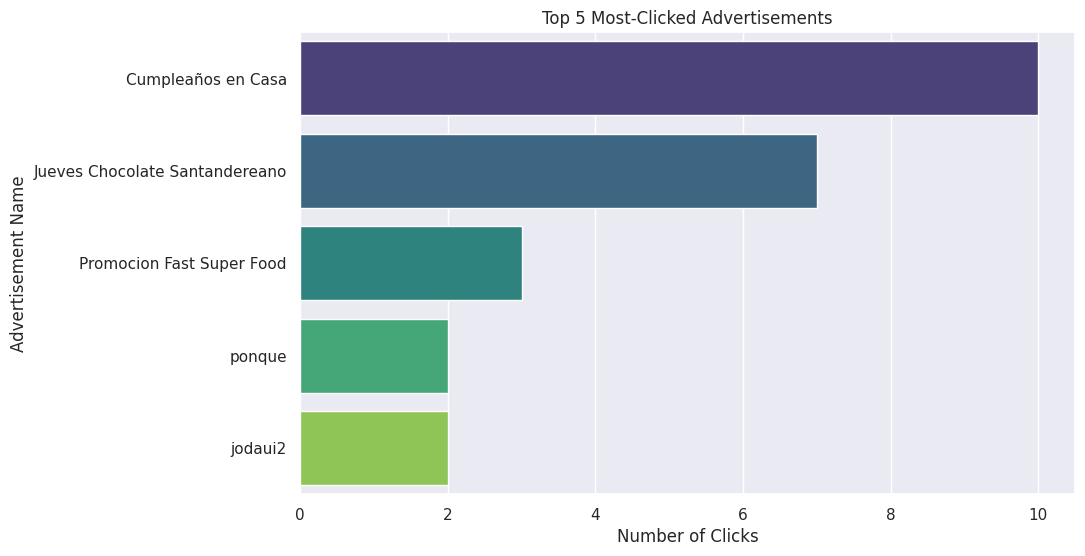

<ipython-input-30-e5b7f4c928d6>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='timesClicked', y='Advertisement Name', data=df.sort_values('timesClicked', ascending=False), palette="coolwarm")


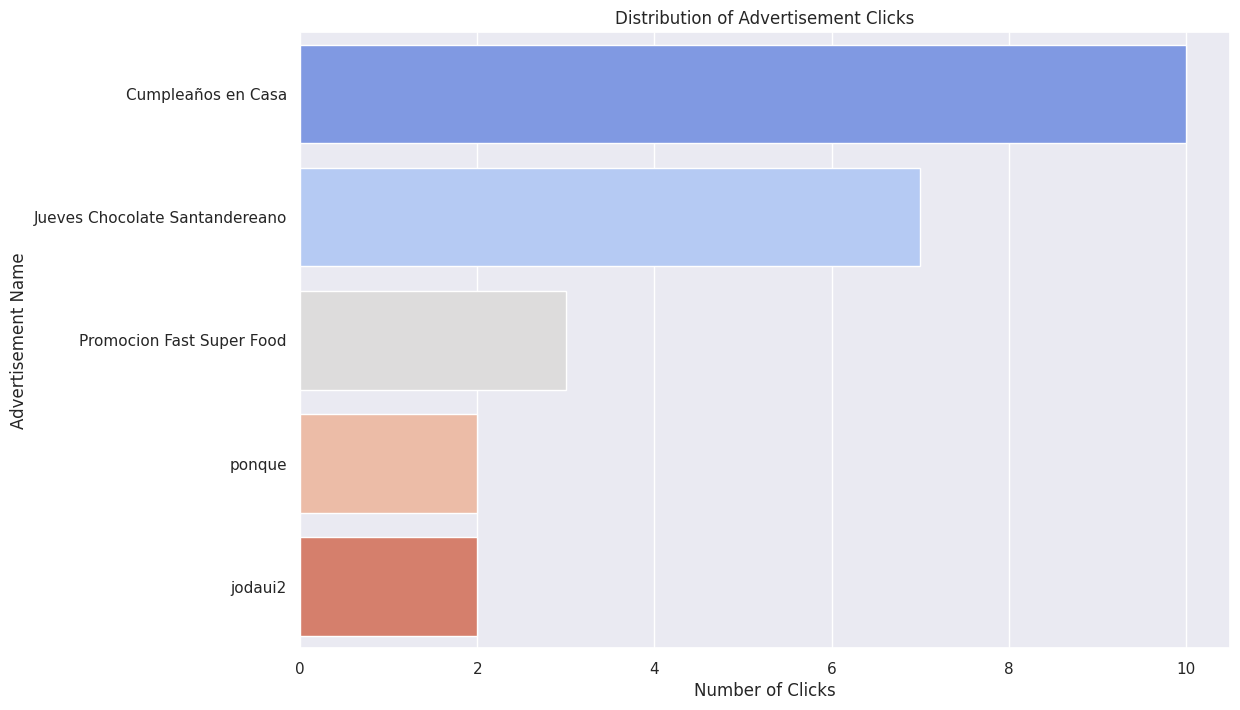

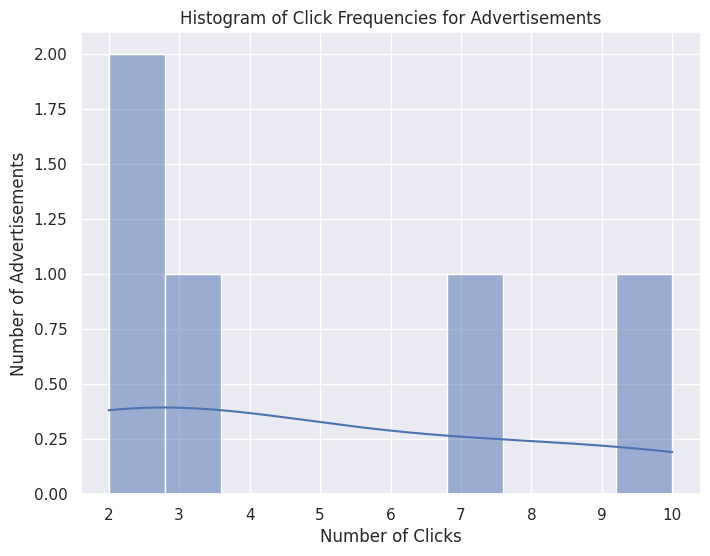

Summary Statistics for Advertisement Clicks:
count     5.000000
mean      4.800000
std       3.563706
min       2.000000
25%       2.000000
50%       3.000000
75%       7.000000
max      10.000000
Name: timesClicked, dtype: float64


In [30]:
import seaborn as sns

# Set up for clean, readable plots
sns.set(style='darkgrid')

# 1. Top 5 Most-Clicked Advertisements
top_clicked_ads = df.nlargest(5, 'timesClicked')
plt.figure(figsize=(10, 6))
sns.barplot(x='timesClicked', y='Advertisement Name', data=top_clicked_ads, palette="viridis")
plt.title('Top 5 Most-Clicked Advertisements')
plt.xlabel('Number of Clicks')
plt.ylabel('Advertisement Name')
plt.show()

# 2. Distribution of Advertisement Clicks (all ads)
plt.figure(figsize=(12, 8))
sns.barplot(x='timesClicked', y='Advertisement Name', data=df.sort_values('timesClicked', ascending=False), palette="coolwarm")
plt.title('Distribution of Advertisement Clicks')
plt.xlabel('Number of Clicks')
plt.ylabel('Advertisement Name')
plt.show()

# 3. Click Frequency Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['timesClicked'], bins=10, kde=True)
plt.title('Histogram of Click Frequencies for Advertisements')
plt.xlabel('Number of Clicks')
plt.ylabel('Number of Advertisements')
plt.show()

# 4. Summary Statistics for Clicks
click_summary = df['timesClicked'].describe()
print("Summary Statistics for Advertisement Clicks:")
print(click_summary)

## **Implementation Business Question 5**

*Which are the schedules of opening and closing of the stores of the app?*

In [ ]:
schedule_data = {
    'Monday_Open': [],
    'Monday_Close': [],
    'Tuesday_Open': [],
    'Tuesday_Close': [],
    'Wednesday_Open': [],
    'Wednesday_Close': [],
    'Thursday_Open': [],
    'Thursday_Close': [],
    'Friday_Open': [],
    'Friday_Close': [],
    'Saturday_Open': [],
    'Saturday_Close': [],
    'Sunday_Open': [],
    'Sunday_Close': []
}

# Populate the dictionary with schedule data
for schedule in df_stores['Schedule']:
    for day in ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']:
        day_cap = day.capitalize()
        times = schedule.get(day, [0, 0])
        if isinstance(times, list) and len(times) == 2:
            schedule_data[f'{day_cap}_Open'].append(times[0])
            schedule_data[f'{day_cap}_Close'].append(times[1])
        else:
            # Handle cases where schedule data is missing or malformed
            schedule_data[f'{day_cap}_Open'].append(0)
            schedule_data[f'{day_cap}_Close'].append(0)

# Convert the dictionary to a DataFrame
df_schedule = pd.DataFrame(schedule_data)

print("Schedule data prepared for box plot.")


Schedule data prepared for box plot.


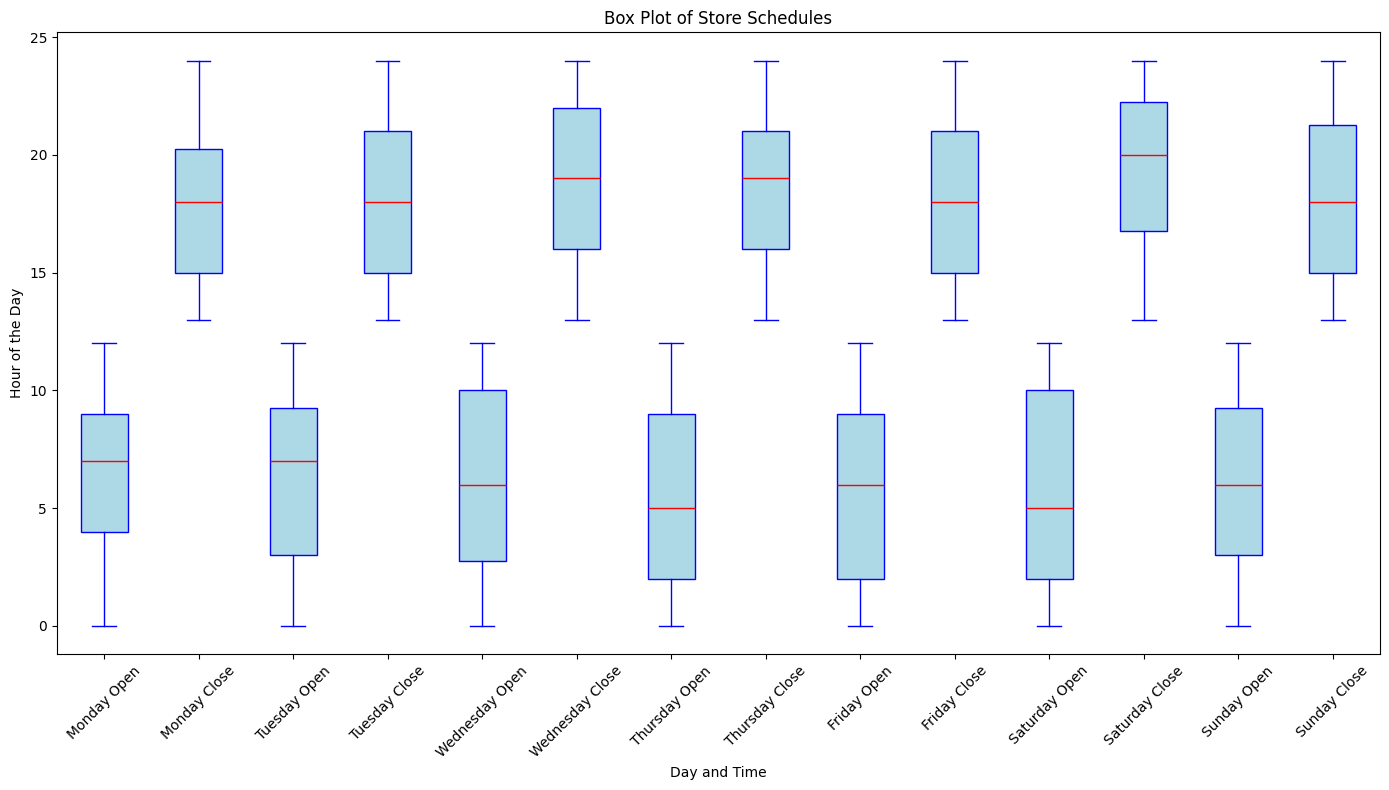

In [ ]:
# Set the plot style for better aesthetics

# Define the figure size
plt.figure(figsize=(14, 8))

# Prepare data for box plot
# We'll plot opening and closing times separately for each day
boxplot_data = []
labels = []

for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    boxplot_data.append(df_schedule[f'{day}_Open'])
    labels.append(f'{day} Open')
    boxplot_data.append(df_schedule[f'{day}_Close'])
    labels.append(f'{day} Close')

plt.boxplot(boxplot_data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(color='blue', markeredgecolor='blue'))

plt.title('Box Plot of Store Schedules')
plt.xlabel('Day and Time')
plt.ylabel('Hour of the Day')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

## **Implementation Business Question 6**

*Which are the stores have the best ranking in the app and which is the distribution of the store ranking?*

The analysis provides crucial insigths that can significantly impact business decisions and overall strategy. Here is why the analysis is important:

**Individual Store Performance**
- By calculating average ratings for each store, businesses can benchmark indiviual store performance against the overall average.
- Knowing the top-rated stores allows businesses to identify best practices that can be replicated.
- Identifying stores with lower ratings helps focus improvement efforts where they are most needed.
- The overall average rating across all stores provides a quick snapshot of general customer satisfaction.

**Category Insights.**
- Average ratings by category help businesses understand which types of products or services are resonating most with customers.
- This information can guide decisions about which categories to expand, maintain, or potentially phase out.
- Companies can allocate more resources (e.g., marketing, staff training) to categories that show promise or need improvement.

In [ ]:
#Reference to the 'stores' collection
stores_collection = db.collection('stores')

#fetch all documents
stores_docs = stores_collection.stream()

#Initialize lists to store data
store_id = []
store_name = []
store_category = []

for doc in stores_docs:
    data = doc.to_dict()
    store_id.append(doc.id)
    store_name.append(data.get('name', 'N/A'))
    store_category.append(data.get('category', 'N/A'))

df_stores = pd.DataFrame({
    'store_id':store_id,
    'name': store_name,
    'category': store_category
})

print(df_stores)


                store_id                      name      category
0   5qfYpJ66eLew9CvDmTEB         Fanta Electronics    Electronic
1   BKUTExZM9h34f8ZSQeEa        Crepes And Waffles      Bakeries
2   CAwmeUPRAZY2CSWkl43i                 Fast Food    Restaurant
3   EmjDoJdCztWy8rZaacwZ                       N/A  restaurante 
4   INYWkEteDhsxeTVJeUSA  Burguer King Electronics    Electronic
5   JLLPCvGOlzJ7dpr6D4oV               Mac Donalds    Restaurant
6   LrupjtaDhefpTlSo28Oq                  Hornitos        Coffee
7   bgsYXfOUTzSgRsYoIXvc           Fast Super Food           Bar
8   olNh6XZeAVdRxgEHawJV        Pollos Hermanos JM    Restaurant
9   umSX5VklT2fZc1If9euj                   Wendy's    Stationery
10  v7k19yvii87S9c3f2T50                 Pizza Hut      Pizzeria
11  vpMbEwQvJ5SBjnzU1TGf        la comida de alejo  restaurante 
12  wO7VkiBRzigpY5bvTfzp                       N/A  restaurante 
13  xHoTnTpEcWklpxCmbBiU           la casa de pepe   restaurante


In [ ]:
# Reference to the 'storesAnalytics' collection
collection_ref = db.collection('storesAnalytics')

# Fetch all documents
docs = collection_ref.stream()

# Initialize lists to store data
store_ids_2 = []
store_ratings = []

for doc in docs:
    data = doc.to_dict()
    store_ids_2.append(data.get('store_id', 'N/A'))
    store_ratings.append(data.get('rating', 0))

# Create a DataFrame
df_stores_analytics = pd.DataFrame({
    'store_id': store_ids_2,
    'rating': store_ratings,
})

print(df_stores_analytics)


                store_id  rating
0   wO7VkiBRzigpY5bvTfzp       4
1   EmjDoJdCztWy8rZaacwZ       3
2   LrupjtaDhefpTlSo28Oq       2
3   JLLPCvGOlzJ7dpr6D4oV       3
4   umSX5VklT2fZc1If9euj       4
5   vpMbEwQvJ5SBjnzU1TGf       2
6   v7k19yvii87S9c3f2T50       5
7   EmjDoJdCztWy8rZaacwZ       4
8   bgsYXfOUTzSgRsYoIXvc       0
9   EmjDoJdCztWy8rZaacwZ       5
10  5qfYpJ66eLew9CvDmTEB       2
11  bgsYXfOUTzSgRsYoIXvc       3
12  CAwmeUPRAZY2CSWkl43i       2
13  CAwmeUPRAZY2CSWkl43i       3
14  olNh6XZeAVdRxgEHawJV       5
15  JLLPCvGOlzJ7dpr6D4oV       2
16  5qfYpJ66eLew9CvDmTEB       4
17  EmjDoJdCztWy8rZaacwZ       4
18  BKUTExZM9h34f8ZSQeEa       5
19  umSX5VklT2fZc1If9euj       3
20  bgsYXfOUTzSgRsYoIXvc       1
21  INYWkEteDhsxeTVJeUSA       3
22  5qfYpJ66eLew9CvDmTEB       3
23  wO7VkiBRzigpY5bvTfzp       4
24  JLLPCvGOlzJ7dpr6D4oV       4
25  BKUTExZM9h34f8ZSQeEa       3
26  umSX5VklT2fZc1If9euj       3
27  BKUTExZM9h34f8ZSQeEa       2
28  xHoTnTpEcWklpxCmbBiU       5
29  vpMbEw

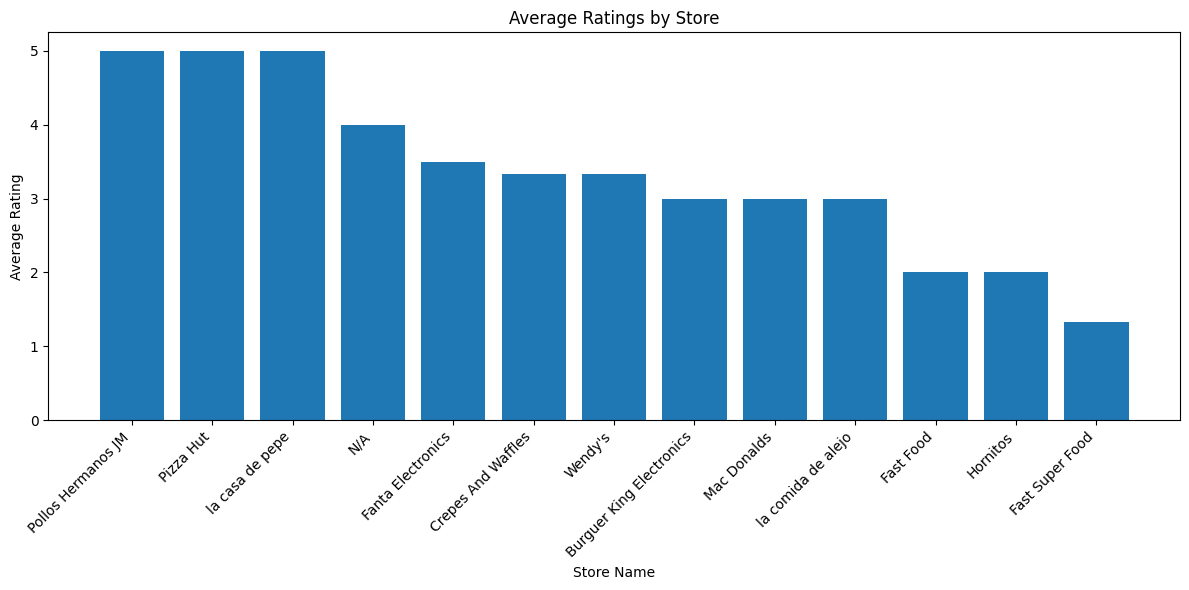


The overall average rating for all stores is: 3.39

Store Ratings:
                        name    rating
8         Pollos Hermanos JM  5.000000
10                 Pizza Hut  5.000000
13           la casa de pepe  5.000000
3                        N/A  4.000000
12                       N/A  4.000000
0          Fanta Electronics  3.500000
1         Crepes And Waffles  3.333333
9                    Wendy's  3.333333
4   Burguer King Electronics  3.000000
5                Mac Donalds  3.000000
11        la comida de alejo  3.000000
2                  Fast Food  2.000000
6                   Hornitos  2.000000
7            Fast Super Food  1.333333

Top 5 stores with the best average rating:
                  name  rating
8   Pollos Hermanos JM     5.0
10           Pizza Hut     5.0
13     la casa de pepe     5.0
3                  N/A     4.0
12                 N/A     4.0

Top 5 stores with the worst average rating:
                  name    rating
5          Mac Donalds  3.000000
11  la

In [ ]:
# Calculate the average rating per store in df_stores_analytics
df_avg_ratings = df_stores_analytics.groupby('store_id')['rating'].mean().reset_index()

# Combine with df_stores to get the store names
df_combined = pd.merge(df_stores, df_avg_ratings, on='store_id')

# Sort by average rating in descending order
df_combined = df_combined.sort_values('rating', ascending=False)

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_combined['name'], df_combined['rating'])
plt.title('Average Ratings by Store')
plt.xlabel('Store Name')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and display the overall average
overall_average = df_combined['rating'].mean()
print(f"\nThe overall average rating for all stores is: {overall_average:.2f}")

# Display table with results
print("\nStore Ratings:")
print(df_combined[['name', 'rating']])

# Top 5 stores with best and worst average rating
print("\nTop 5 stores with the best average rating:")
print(df_combined[['name', 'rating']].head())

print("\nTop 5 stores with the worst average rating:")
print(df_combined[['name', 'rating']].tail())

# Update ratings in the 'stores' collection in Firebase
def update_store_ratings(df):
    batch = db.batch()
    for _, row in df.iterrows():
        store_ref = stores_collection.document(row['store_id'])
        batch.update(store_ref, {'rating': row['rating']})

    # Execute the batch update
    batch.commit()
    print(f"\nUpdated ratings for {len(df)} stores in Firebase.")

# Call the function to update the ratings
update_store_ratings(df_combined)



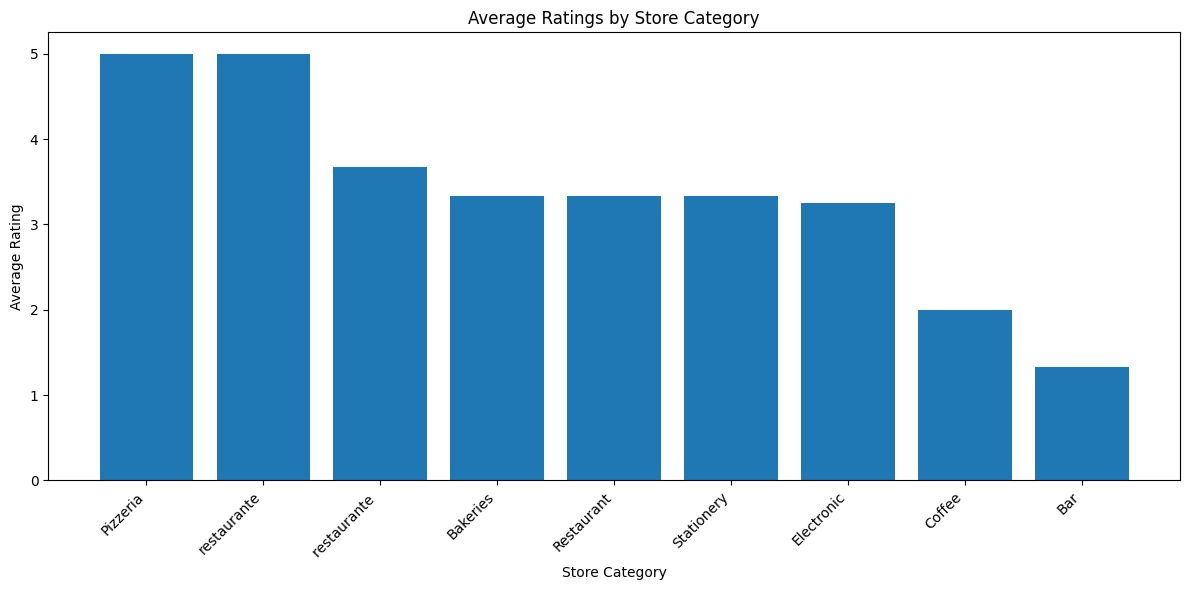

Average ratings by store category:
       category    rating
4      Pizzeria  5.000000
7   restaurante  5.000000
8  restaurante   3.666667
0      Bakeries  3.333333
5    Restaurant  3.333333
6    Stationery  3.333333
3    Electronic  3.250000
2        Coffee  2.000000
1           Bar  1.333333

The overall average rating for all categories is: 3.36

Top 3 categories with the best average rating:
       category    rating
4      Pizzeria  5.000000
7   restaurante  5.000000
8  restaurante   3.666667

Bottom 3 categories with the worst average rating:
     category    rating
3  Electronic  3.250000
2      Coffee  2.000000
1         Bar  1.333333


<Figure size 1400x600 with 0 Axes>

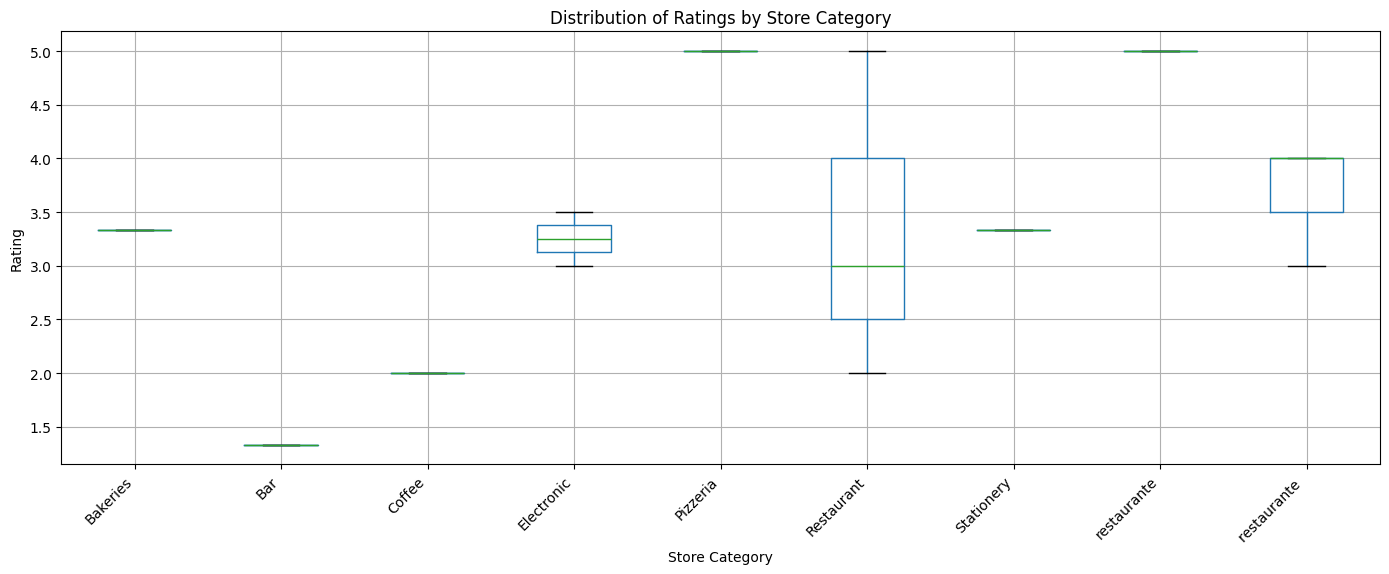

In [ ]:
# Calculate average rating per store in df_stores_analytics
df_avg_ratings = df_stores_analytics.groupby('store_id')['rating'].mean().reset_index()

# Combine with df_stores to get store names and categories
df_combined = pd.merge(df_stores, df_avg_ratings, on='store_id')

# Calculate average rating by category
df_category_ratings = df_combined.groupby('category')['rating'].mean().reset_index()
df_category_ratings = df_category_ratings.sort_values('rating', ascending=False)

# Create bar chart for average ratings by category
plt.figure(figsize=(12, 6))
plt.bar(df_category_ratings['category'], df_category_ratings['rating'])
plt.title('Average Ratings by Store Category')
plt.xlabel('Store Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display table with results by category
print("Average ratings by store category:")
print(df_category_ratings)

# Calculate and display the overall average
overall_average = df_category_ratings['rating'].mean()
print(f"\nThe overall average rating for all categories is: {overall_average:.2f}")

# Additional analysis: Top 3 and Bottom 3 categories
print("\nTop 3 categories with the best average rating:")
print(df_category_ratings.head(3))

print("\nBottom 3 categories with the worst average rating:")
print(df_category_ratings.tail(3))

# Boxplot to show rating distribution by category
plt.figure(figsize=(14, 6))
df_combined.boxplot(column='rating', by='category', figsize=(14, 6))
plt.title('Distribution of Ratings by Store Category')
plt.suptitle('')  # This removes the automatic suptitle added by pandas
plt.xlabel('Store Category')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# **Business Questions** - Sprint 3

## **Implementation Business Question JEFFERSON**

*What is the average number of effective app entries triggered by notifications of new discounts and promotions?*

This question is classified as Type 3 because it focuses on analyzing how often users open the app after receiving a notification about new discounts or promotions, we can understand how well these notifications capture users' attention and prompt them to interact with the app. A high average could indicate that notifications are well-targeted and relevant, motivating users to explore deals and engage with the app regularly. Conversely, a low average might suggest the need for more personalized or compelling notifications to enhance their impact and increase user retention.

Each time a new discount is added, users who have interacted with that store are notified. We track the number of notifications sent and the number of subsequent app entries. This data is stored, creating a record for each advertisement with its corresponding notification count and effective entry count.

After saving this information, we retrieve it from Firebase and use a pandas DataFrame to manage and process the records.

In [45]:
# Instance of collection analytics business question 1
coleccion_analitics_business_question_3 = db.collection('AnalyticsBusinessQuestions').document('sprint3').collection('businessQuestion3')

# List of documents from the collection
docs = list(coleccion_analitics_business_question_3.stream())

# Transforme from firebase collection to pandas dataframe
data_df_analytics_business_question_3 = []
for doc in docs:
    data_dict_df_analytics_business_question_3 = doc.to_dict()
    data_dict_df_analytics_business_question_3['document_id'] = doc.id
    data_df_analytics_business_question_3.append(data_dict_df_analytics_business_question_3)

df_analytics_business_question_3 = pd.DataFrame(data_df_analytics_business_question_3)
df_analytics_business_question_3.head()

,notifications,entries,advertisementId,document_id
0,8,3,n7lUkKdgo4pwrrN3Cq39,3bA5QF65y4QcJHjmphnO
1,20,5,2AewV3d1A3L6SGIsXna3,CFGLw7jkZIYnvwAvQ6Z5
2,10,8,LgJTfAtnOdVfwsOKOETx,f8417uvZH5ZJd1ssOIqw


Next, we transform the data to calculate the minimum, maximum, and average of conversion rate. These statistics, along with the distribution of conversion rate, are then visualized in a plot.

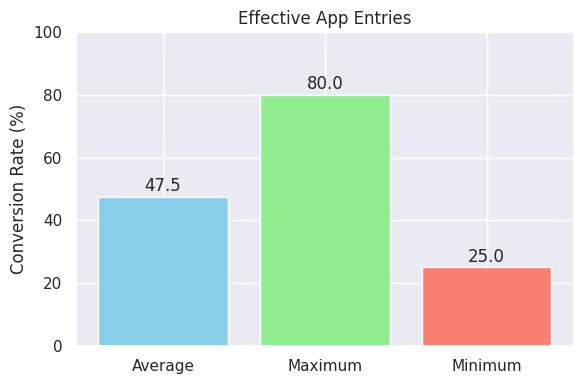

In [46]:
# Calculate the average, maximum, and minimum conversion rate
df_analytics_business_question_3['conversion_rate'] = (df_analytics_business_question_3['entries'] / df_analytics_business_question_3['notifications']) * 100
conversion_avg = df_analytics_business_question_3['conversion_rate'].mean()
conversion_max = df_analytics_business_question_3['conversion_rate'].max()
conversion_min = df_analytics_business_question_3['conversion_rate'].min()

# Create a new DataFrame for the summary plot
summary_data = {
    'Metric': ['Average', 'Maximum', 'Minimum'],
    'Conversion Rate (%)': [conversion_avg, conversion_max, conversion_min]
}
df_summary = pd.DataFrame(summary_data)

# Plot the average, maximum, and minimum conversion rates
plt.figure(figsize=(6, 4))
bars = plt.bar(df_summary['Metric'], df_summary['Conversion Rate (%)'], color=['skyblue', 'lightgreen', 'salmon'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, round(yval, 2), ha='center', va='bottom')
plt.ylabel("Conversion Rate (%)")
plt.ylim(0, 100)
plt.title("Effective App Entries")
plt.tight_layout()
plt.show()

## **Implementation Business Question JUAN FELIPE**

*What is the average number of people who shop in the stores on each day of the week?*

## **Implementation Business Question ALEJANDRO**

*What are the most popular loyalty programs among users?*